# TTS Inference Model Selection

This notebook can be used to generate audio samples using either NeMo's pretrained models or after training NeMo TTS models. This notebook supports all TTS models and is intended to showcase different models and how their results differ.

# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [ ]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# # If you're using Google Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[tts]

## Models

First we pick the models that we want to use. Currently supported models are:

End-to-End Models:
- [FastPitch_HifiGan_E2E](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_e2e_fastpitchhifigan)
- [FastSpeech2_HifiGan_E2E](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_e2e_fastspeech2hifigan)

Mel Spectrogram Generators:
- [Tacotron 2](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_tacotron2)
- [Glow-TTS](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_glowtts)
- [TalkNet](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_talknet)
  - <span style="color:red"> NOTE: TalkNet loading is not working in main. Please use r1.2.0 for TalkNet inference </span>
- [FastPitch](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_fastpitch)
- [FastSpeech2](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_fastspeech_2)
- [Mixer-TTS](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_mixertts_lj)
- [Mixer-TTS-X](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_mixerttsx_lj)

Audio Generators
- [WaveGlow](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_waveglow_88m)
- [SqueezeWave](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_squeezewave)
- [UniGlow](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_uniglow)
- [MelGAN](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_melgan)
- [HiFiGAN](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_hifigan)
- Griffin-Lim

In [89]:
from ipywidgets import Select, HBox, Label
from IPython.display import display

supported_e2e = ["fastpitch_hifigan", "fastspeech2_hifigan", None]
# supported_spec_gen = ["tacotron2", "glow_tts", "talknet", "fastpitch", "fastspeech2", None]
supported_spec_gen = ["tacotron2", "glow_tts", "fastpitch", "fastspeech2", "mixertts", "mixerttsx", None]
supported_audio_gen = ["waveglow", "squeezewave", "uniglow", "melgan", "hifigan", "griffin-lim", None]

print("Select the model(s) that you want to use. Please choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")
e2e_selector = Select(options=supported_e2e, value=None)
spectrogram_generator_selector = Select(options=supported_spec_gen, value=None)
audio_generator_selector = Select(options=supported_audio_gen, value=None)
display(HBox([e2e_selector, Label("OR"), spectrogram_generator_selector, Label("+"), audio_generator_selector]))

Select the model(s) that you want to use. Please choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.


In [132]:
e2e_model = e2e_selector.value
spectrogram_generator = spectrogram_generator_selector.value
audio_generator = audio_generator_selector.value

if e2e_model is None and spectrogram_generator is None and audio_generator is None:
    raise ValueError("No models were chosen. Please return to the previous step and choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")

if e2e_model and (spectrogram_generator or audio_generator):
    raise ValueError(
        "An end-to-end model was chosen and either a spectrogram generator or a vocoder was also selected. For end-to-end models, please select `None` "
        "in the second and third column to continue. For the two step pipeline, please select `None` in the first column to continue."
    )

if (spectrogram_generator and audio_generator is None) or (audio_generator and spectrogram_generator is None):
    raise ValueError("In order to continue with the two step pipeline, both the spectrogram generator and the audio generator must be chosen, but one was `None`")
    

## Load model checkpoints

Next we load the pretrained model provided by NeMo. All NeMo models have two functions to help with this

- list_available_models(): This function will return a list of all pretrained checkpoints for that model
- from_pretrained(): This function will download the pretrained checkpoint, load it, and return an instance of the model

Below we will use `from_pretrained` to load the chosen models from above.

In [137]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder, TextToWaveform


def load_spectrogram_model():
    override_conf = None
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "tts_en_tacotron2"
    elif spectrogram_generator == "glow_tts":
        from nemo.collections.tts.models import GlowTTSModel
        pretrained_model = "tts_en_glowtts"
        import wget
        from pathlib import Path
        if not Path("cmudict-0.7b").exists():
            filename = wget.download("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b")
            filename = str(Path(filename).resolve())
        else:
            filename = str(Path("cmudict-0.7b").resolve())
        conf = SpectrogramGenerator.from_pretrained(pretrained_model, return_config=True)
        if "params" in conf.parser:
            conf.parser.params.cmu_dict_path = filename
        else:
            conf.parser.cmu_dict_path = filename
        override_conf = conf
    elif spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetSpectModel
        pretrained_model = "tts_en_talknet" 
    elif spectrogram_generator == "fastpitch":
        from nemo.collections.tts.models import FastPitchModel
        pretrained_model = "tts_en_fastpitch"
    elif spectrogram_generator == "fastspeech2":
        from nemo.collections.tts.models import FastSpeech2Model
        pretrained_model = "tts_en_fastspeech2"
    elif spectrogram_generator == "mixertts":
        from nemo.collections.tts.models import MixerTTSModel
        pretrained_model = "tts_en_lj_mixertts"
    elif spectrogram_generator == "mixerttsx":
        from nemo.collections.tts.models import MixerTTSModel
        pretrained_model = "tts_en_lj_mixerttsx"
    else:
        raise NotImplementedError
    
    # TODO(otatanov): change it
    if pretrained_model == "tts_en_lj_mixertts":
        model = MixerTTSModel.restore_from("/home/otatanov/data/exp_manager_folder/lj_new_mixer_tts_nqvz8WBCVh62R/checkpoints/tts_en_lj_mixertts.nemo")
    elif pretrained_model == "tts_en_lj_mixerttsx":
        model = MixerTTSModel.restore_from("/home/otatanov/data/exp_manager_folder/lj_new_mixer_tts_x_5AH8oxTDjGagz/checkpoints/tts_en_lj_mixerttsx.nemo")
    else:
        model = SpectrogramGenerator.from_pretrained(pretrained_model, override_config_path=override_conf)
    
    if spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetPitchModel
        pitch_model = TalkNetPitchModel.from_pretrained(pretrained_model, override_config_path=override_conf)
        from nemo.collections.tts.models import TalkNetDursModel
        durs_model = TalkNetDursModel.from_pretrained(pretrained_model, override_config_path=override_conf)
        model.add_module('_pitch_model', pitch_model)
        model.add_module('_durs_model', durs_model)
    
    return model


def load_vocoder_model():
    RequestPseudoInverse = False
    TwoStagesModel = False
    strict=True
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "tts_waveglow"
        strict=False
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel
        pretrained_model = "tts_squeezewave"
    elif audio_generator == "uniglow":
        from nemo.collections.tts.models import UniGlowModel
        pretrained_model = "tts_uniglow"
    elif audio_generator == "melgan":
        from nemo.collections.tts.models import MelGanModel
        pretrained_model = "tts_melgan"
    elif audio_generator == "hifigan":
        from nemo.collections.tts.models import HifiGanModel
        spectrogram_generator2ft_hifigan = {
            "mixertts": "tts_en_lj_hifigan_ft_mixertts",
            "mixerttsx": "tts_en_lj_hifigan_ft_mixerttsx"
        }
        pretrained_model = spectrogram_generator2ft_hifigan.get(spectrogram_generator, "tts_hifigan")    
    elif audio_generator == "griffin-lim":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': 1024, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': 22050, 'n_fft': 1024, 
                                   'mel_fmin': 0, 'mel_fmax': 8000, 'mel_freq': 80}}}
        model = TwoStagesModel(cfg)            
        TwoStagesModel = True
    else:
        raise NotImplementedError

    if not TwoStagesModel:
        # TODO(otatanov): change it
        if pretrained_model == "tts_en_lj_hifigan_ft_mixertts":
            model = HifiGanModel.restore_from("/home/otatanov/data/exp_manager_folder/lj_hifigan_nRbQjb7UMp1Ob/checkpoints/tts_en_lj_hifigan_ft_mixertts.nemo")
        elif pretrained_model == "tts_en_lj_hifigan_ft_mixerttsx":
            model = HifiGanModel.restore_from("/home/otatanov/data/exp_manager_folder/lj_hifigan_dVxo3NpAXudNU/checkpoints/tts_en_lj_hifigan_ft_mixerttsx.nemo")
        else:
            model = Vocoder.from_pretrained(pretrained_model, strict=strict)
        
    return model

def load_e2e_model():
    if e2e_model == "fastpitch_hifigan":
        from nemo.collections.tts.models import FastPitchHifiGanE2EModel
        pretrained_model = "tts_en_e2e_fastpitchhifigan"
    elif e2e_model == "fastspeech2_hifigan":
        from nemo.collections.tts.models import FastSpeech2HifiGanE2EModel
        pretrained_model = "tts_en_e2e_fastspeech2hifigan"
    else:
        raise NotImplementedError

    model = TextToWaveform.from_pretrained(pretrained_model)
    return model

emodel = None
spec_gen = None
vocoder = None
if e2e_model:
    emodel = load_e2e_model().eval().cuda()
else:
    spec_gen = load_spectrogram_model().eval().cuda()
    vocoder = load_vocoder_model().eval().cuda()

[NeMo I 2021-12-21 02:07:56 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2021-12-21 02:08:00 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.MixerTTSDataset
      manifest_filepath: lj_train.json
      sample_rate: 22050
      sup_data_path: tts_ds_align_prior_matrix_pitch_char
      sup_data_types:
      - align_prior_matrix
      - pitch
      - lm_tokens
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      lm_model: albert
      text_normalizer:
        _target_: nemo_text_processing.text_normalization.normalize.Normalizer
        lang: en
        input_case: cased
        whitelist: nem

[NeMo I 2021-12-21 02:08:04 features:264] PADDING: 1
[NeMo I 2021-12-21 02:08:04 features:281] STFT using torch
[NeMo I 2021-12-21 02:08:04 save_restore_connector:149] Model MixerTTSModel was successfully restored from /home/otatanov/data/exp_manager_folder/lj_new_mixer_tts_x_5AH8oxTDjGagz/checkpoints/tts_en_lj_mixerttsx.nemo.


[NeMo W 2021-12-21 02:08:06 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: lj_train.json
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 1
    
[NeMo W 2021-12-21 02:08:06 modelPT:137] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: lj_val.json
      min_duration: 3
      n_segments: 66048
    dataloader_params:
      drop_last: false


[NeMo I 2021-12-21 02:08:06 features:264] PADDING: 0
[NeMo I 2021-12-21 02:08:06 features:281] STFT using torch
[NeMo I 2021-12-21 02:08:06 features:283] STFT using exact pad
[NeMo I 2021-12-21 02:08:06 features:264] PADDING: 0
[NeMo I 2021-12-21 02:08:06 features:281] STFT using torch
[NeMo I 2021-12-21 02:08:06 features:283] STFT using exact pad
[NeMo I 2021-12-21 02:08:06 save_restore_connector:149] Model HifiGanModel was successfully restored from /home/otatanov/data/exp_manager_folder/lj_hifigan_dVxo3NpAXudNU/checkpoints/tts_en_lj_hifigan_ft_mixerttsx.nemo.


## Inference

Now that we have downloaded the model checkpoints and loaded them into memory. Let's define a short infer helper function that takes a string, and our models to produce speech.

Notice that the NeMo TTS model interface is fairly simple and standardized across all models.

End-to-end models have two helper functions:
- parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
- convert_text_to_waveform(): Accepts a batch of tokenized text and returns a torch.tensor that represents a batch of raw audio

Mel Spectrogram generators have two helper functions:

- parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
- generate_spectrogram(): Accepts a batch of tokenized text and returns a torch.tensor that represents a batch of spectrograms

Vocoder have just one helper function:

- convert_spectrogram_to_audio(): Accepts a batch of spectrograms and returns a torch.tensor that represents a batch of raw audio

In [134]:
def infer(end2end_model, spec_gen_model, vocoder_model, str_input):
    parser_model = end2end_model or spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        if end2end_model is None:
            gen_spec_kwargs = {}
            
            if spectrogram_generator == "mixerttsx":
                gen_spec_kwargs["raw_texts"] = [str_input]
            
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, **gen_spec_kwargs)
            audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
            
            if audio_generator == "hifigan":
                audio = vocoder_model._bias_denoise(audio, spectrogram).squeeze(1)
        else:
            spectrogram = None
            audio = end2end_model.convert_text_to_waveform(tokens=parsed)[0]
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

Now that everything is set up, let's give an input that we want our models to speak

In [135]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(emodel, spec_gen, vocoder, text_to_generate)

Input what you want the model to say: After our model generates the audio, let's go ahead and play it. We can


# Results

After our model generates the audio, let's go ahead and play it. We can also visualize the spectrogram that was produced from the first stage model if a spectrogram generator was used.

In [131]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

ipd.Audio(audio, rate=22050)

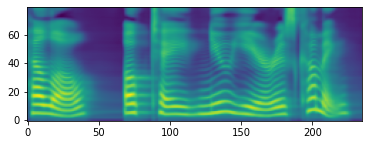

In [25]:
%matplotlib inline
if spec is not None:
    imshow(spec, origin="lower")
    plt.show()